In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
sr = 1000
f1 = 4
t1 = np.arange(-500,1200)+500
f2 = 30
t2 = np.arange(-500,1200)+500
f3 = 17
t3 = np.arange(800,2500)+500
f4 = 30
t4 = np.arange(800,2500)+500

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(0,30,10)]]),\
                    sr, \
                    utils.create_decay(len(t1),1,400))
net2, F2_true, _  = utils.make_network(f2, len(t2), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-20,30,10)]]),\
                    sr, \
                    utils.create_decay(len(t2),1,400))
net3, F3_true, _  = utils.make_network(f3, len(t3), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,0,10)]]),\
                    sr, \
                    utils.create_decay(len(t3),400,1))
gauss = scipy.stats.norm(800, 200).pdf(np.arange(1700))
gauss = gauss / np.max(gauss) + 0.3
net4, F4_true, _  = utils.make_network(f4, len(t4), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(30,-10,10)]]),\
                    sr, \
                    gauss*utils.create_decay(len(t4),400,1))
x = np.zeros((100,3000))
x[:,t1] += net1
x[:,t2] += net2
x[:,t3] += net3
x[:,t4] += net4
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) / sr

Text(0, 0.5, 'channel')

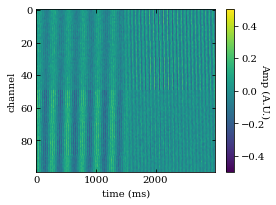

In [3]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(x, aspect='auto', vmin=-0.5, vmax=0.5)
cbar = fig.colorbar(cax)
cbar.set_label('Amp (A.U.)', rotation=270)
ax.set_xlabel('time (ms)')
ax.set_ylabel('channel')

In [4]:
model_4 = nsdmd.NSDMD(opt_rank=4, sim_thresh_phi_amp=0.92, grad_alpha=0.1, sim_thresh_phi_phase=10)
model_4.fit_opt(x, t, sr)

model_2 = nsdmd.NSDMD(opt_rank=2, sim_thresh_phi_amp=0.97, grad_alpha=0.1, sim_thresh_phi_phase=10)
model_2.fit_opt(x, t, sr)

#for 2 mode 30 hz guess
model_2_30 = nsdmd.NSDMD(opt_rank=2, sim_thresh_phi_amp=0.97, grad_alpha=0.1, sim_thresh_phi_phase=10)
model_2_30.fit_opt(x, t, sr, np.array([30,-30]))

model_6 = nsdmd.NSDMD(opt_rank=6, sim_thresh_phi_amp=0.92, grad_alpha=0.1, sim_thresh_phi_phase=10, \
                      feature_f_method='grad', verbose=True)
model_6.fit_opt(x, t, sr)

Starting OPT-DMD...


Text(0, 0.5, 'freq (Hz)')

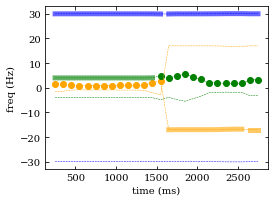

In [5]:
model = model_6 # To plot this model

plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, model.opt_stride/sr, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange', 'green', 'red']
for i in range(len(group_idx)):
    ax.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            ax.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            ax.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])
ax.set_xlabel('time (ms)')
ax.set_ylabel('freq (Hz)')

In [6]:
model_4.fit_reduction(x, len(t), sr)
model_2.fit_reduction(x, len(t), sr)
model_2_30.fit_reduction(x, len(t), sr)
model_6.fit_reduction(x, len(t), sr)

Gathering modes...
Found 30 modes
Number of modes: 30/30, stopping at 0
Number of modes: 29/30, stopping at 0
Number of modes: 28/30, stopping at 0
Number of modes: 27/30, stopping at 0
Number of modes: 26/30, stopping at 0
Number of modes: 25/30, stopping at 0
Number of modes: 24/30, stopping at 0
Number of modes: 23/30, stopping at 0
Number of modes: 22/30, stopping at 0
Number of modes: 21/30, stopping at 0
Number of modes: 20/30, stopping at 0
Number of modes: 19/30, stopping at 0
Number of modes: 18/30, stopping at 0
Number of modes: 17/30, stopping at 0
Number of modes: 16/30, stopping at 0
Number of modes: 15/30, stopping at 0
Number of modes: 14/30, stopping at 0
Number of modes: 13/30, stopping at 0
Number of modes: 12/30, stopping at 0
Number of modes: 11/30, stopping at 0
Number of modes: 10/30, stopping at 0
Number of modes: 9/30, stopping at 0
Number of modes: 8/30, stopping at 0
Number of modes: 7/30, stopping at 0
Number of modes: 6/30, stopping at 0
Number of modes: 5/3

Text(0, 0.5, 'Cosine Distance')

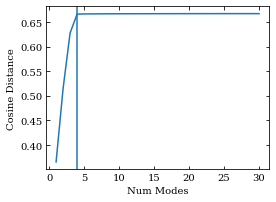

In [7]:
model = model_6 # To plot this model

plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

ax.plot(model.num_modes_, model.errors_)
ax.axvline(4)
ax.set_xlabel('Num Modes')
ax.set_ylabel('Cosine Distance')

In [8]:
model_4.fit_f(x, len(t), sr, 4)
model_2.fit_f(x, len(t), sr, 2)
model_2_30.fit_f(x, len(t), sr, 2)
model_6.fit_f(x, len(t), sr, 4)

Text(0, 0.5, 'True f(t)')

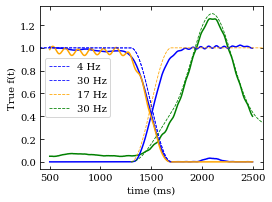

In [9]:
model = model_6 #to plot

plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

colors = ['blue', 'green', 'blue', 'orange', 'blue', 'green']
for i,f in enumerate(model.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

ax.plot(t1, np.mean(F1_true, axis=0), color=colors[2], label=str(f1)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F2_true, axis=0), color=colors[0], label=str(f2)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t3, np.mean(F3_true, axis=0), color=colors[3], label=str(f3)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t4, np.mean(F4_true, axis=0), color=colors[1], label=str(f4)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('True f(t)')

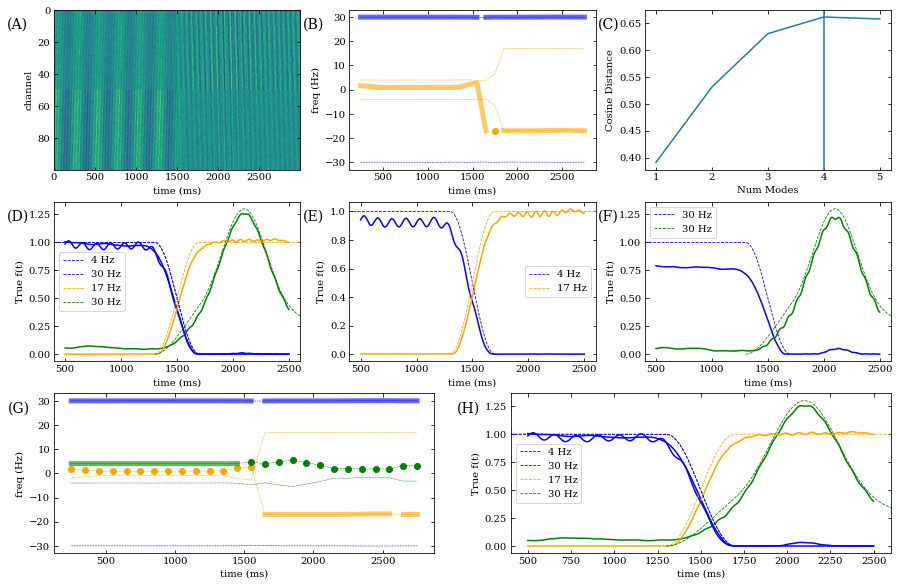

In [77]:
#Plot Figure

plt.rc('font', family='serif')
fig = plt.figure(figsize=(15,10))

#Data
ax = fig.add_subplot(331)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(x, aspect='auto', vmin=-0.5, vmax=0.5)
# cbar = fig.colorbar(cax)
# cbar.set_label('Amp (A.U.)', rotation=270)
ax.set_xlabel('time (ms)')
ax.set_ylabel('channel')
ax.text(-0.19, 0.95, '(A)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#4 mode Similarity
ax = fig.add_subplot(332)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

group_idx = nsdmd.group_by_similarity(model_4.freqs_, model_4.phis_, model_4.opt_stride/sr, \
                                      model_4.sim_thresh_freq, model_4.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange', 'green', 'red']
for i in range(len(group_idx)):
    ax.plot(x_extent, model_4.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            ax.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            ax.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])
ax.set_xlabel('time (ms)')
ax.set_ylabel('freq (Hz)')
ax.text(-0.19, 0.95, '(B)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#4 Mode Cosine Error
ax = fig.add_subplot(333)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
ax.plot(model_4.num_modes_, model_4.errors_)
ax.axvline(4)
ax.set_xlabel('Num Modes')
ax.set_ylabel('Cosine Distance')
ax.text(-0.19, 0.95, '(C)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#4 Mode f(t)
ax = fig.add_subplot(334)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
colors = ['blue', 'green', 'blue', 'orange']
for i,f in enumerate(model_4.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

ax.plot(t1, np.mean(F1_true, axis=0), color=colors[2], label=str(f1)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F2_true, axis=0), color=colors[0], label=str(f2)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t3, np.mean(F3_true, axis=0), color=colors[3], label=str(f3)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t4, np.mean(F4_true, axis=0), color=colors[1], label=str(f4)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('True f(t)')
ax.text(-0.19, 0.95, '(D)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#2 Mode f(t)
ax = fig.add_subplot(335)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
colors = ['blue', 'orange']
for i,f in enumerate(model_2.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

ax.plot(t1, np.mean(F1_true, axis=0), color=colors[0], label=str(f1)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t3, np.mean(F3_true, axis=0), color=colors[1], label=str(f3)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('True f(t)')
ax.text(-0.19, 0.95, '(E)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#2 Mode 30 Hz f(t)
ax = fig.add_subplot(336)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
colors = ['blue', 'green']
for i,f in enumerate(model_2_30.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

ax.plot(t2, np.mean(F2_true, axis=0), color=colors[0], label=str(f2)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t4, np.mean(F4_true, axis=0), color=colors[1], label=str(f4)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('True f(t)')
ax.text(-0.19, 0.95, '(F)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#6 mode Similarity
ax = fig.add_subplot(325)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

group_idx = nsdmd.group_by_similarity(model_6.freqs_, model_6.phis_, model_6.opt_stride/sr, \
                                      model_6.sim_thresh_freq, model_6.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange', 'green', 'red']
for i in range(len(group_idx)):
    ax.plot(x_extent, model_6.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            ax.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            ax.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])
ax.set_xlabel('time (ms)')
ax.set_ylabel('freq (Hz)')
ax.text(-0.12, 0.95, '(G)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#6 Mode f(t)
ax = fig.add_subplot(326)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
colors = ['blue', 'green', 'orange', 'blue']
for i,f in enumerate(model_6.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

ax.plot(t1, np.mean(F1_true, axis=0), color=colors[3], label=str(f1)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F2_true, axis=0), color=colors[0], label=str(f2)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t3, np.mean(F3_true, axis=0), color=colors[2], label=str(f3)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t4, np.mean(F4_true, axis=0), color=colors[1], label=str(f4)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('True f(t)')
ax.text(-0.14, 0.95, '(H)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

# plt.savefig('figs/two_net_all.svg', bbox_inches='tight')

plt.show()

In [13]:
model = model_6 #to plot
x_rec = model.transform(x, len(t), sr)

Text(0, 0.5, 'Channel')

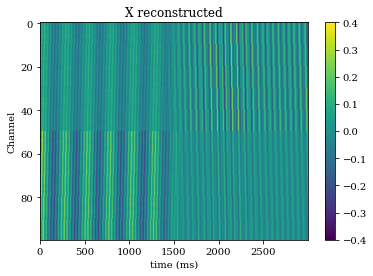

In [11]:
plt.imshow(x_rec, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X reconstructed')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0, 0.5, 'Channel')

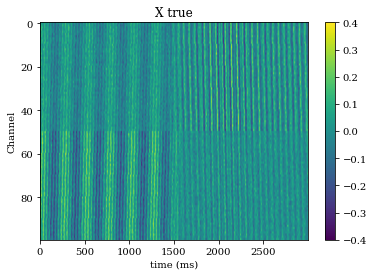

In [12]:
plt.imshow(x, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X true')
plt.xlabel('time (ms)')
plt.ylabel('Channel')